From the original full BindingDB database, we extracted a smaller, more manageable dataset by selecting only ligand-target pairs studied on viral organisms associated with sexually transmitted diseases, such as Human Immunodeficiency Virus (HIV). This subset is saved in the same `.tsv` file format as the original database.

For more details on the extraction process, refer to [`./src/data/std_extraction.ipynb`](./src/data/std_extraction.ipynb).


In [1]:
#import libraries and scripts

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils import data_utils, evaluation_utils, general_utils
from src.data.some_dataloader import get_dataset
from src.scripts import rdkit_extraction
from src.utils import evaluation_utils
sns.set_palette('colorblind')

We import the reduced dataset with the custom dataloader `get_dataset`. The reduced dataset contains only viruses responsible for STDs as target organisms

In [2]:
#read the std database

df = get_dataset()
print(f'STDs dataset rows: {df.shape[0]}')
print(f'STDs dataset columns: {df.shape[1]}')

STDs dataset rows: 30156
STDs dataset columns: 86


In the dataset, four affinity metric are available:

1. **Ki (Inhibition Constant)**: Represents the concentration at which an inhibitor ligand occupies 50% of the receptor or enzyme sites, assuming no competing ligands are present. It quantifies the affinity of the inhibitor for the target under equilibrium conditions.

2. **IC50 (Half Maximal Inhibitory Concentration)**: Represents the concentration of a drug needed to inhibit a specific biological or biochemical function by 50%. It measures how much drug is required to achieve a halfway inhibition of the target activity in a given experimental setup.

3. **Kd (Dissociation Constant)**: Represents the concentration at which 50% of the binding sites on the target (e.g., receptor or enzyme) are occupied by the ligand. It quantifies the equilibrium affinity between a ligand and its target, with lower values indicating tighter binding.

4. **EC50 (Half Maximal Effective Concentration)**: Represents the concentration of a drug needed to produce 50% of its maximal effect in a biological system. It is an indicator of the drug's potency, reflecting the concentration required to achieve a halfway maximal response.

These metrics are interrelated but not directly interchangeable, although an approximate relationship between **Ki** and **IC50**, the Cheng-Prusoff equation, does exist. Unfortunately, strict conditions need to be satisfies, so we won't use it in our analysis.

Therefore, in the next cells we will select the most represented metric in our dataset and get rid of rows where it's not provided.

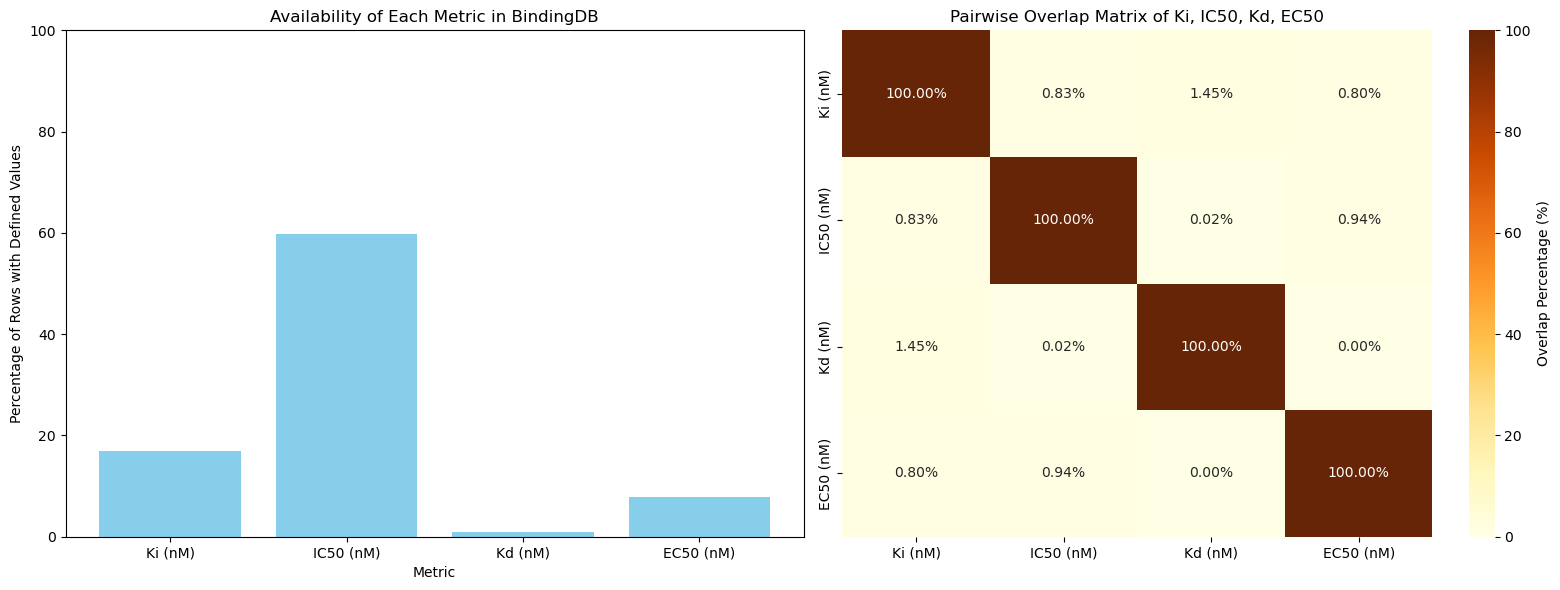

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
ax = axes.flatten()

evaluation_utils.plot_metric_availability(df, ax=ax[0])
evaluation_utils.plot_overlap_matrix(df, ax=ax[1])

plt.tight_layout()
plt.show()

We observe that IC50 is given in more than 50% of the rows, while the other metrics are less represented. In the overlap matrix, we also observe that metrics rarely overlap, so it makes sense to pick only one of the four for the analysis.  

In the next cell, we use the `data_utils.select_metric` function to select only rows with IC50 for our analyses.  

We also get rid of columns where more than 50% of entries are `NaN` through the `data_utils.clean_na_columns` function. Non-numeric entries that were not `NaN` (e.g., `'> 50000'`) were also removed, since they would negatively affect the computation of statistics like the mean.



In [3]:
df = data_utils.select_metric(df, 'IC50 (nM)')
df = data_utils.clean_na_columns(df)
print(f'Rows of STD dataset where IC50 is given: {df.shape[0]}')
print(f'Columns of STD dataset where nan rows are less than 50% of the total: {df.shape[1]}')

Rows of STD dataset where IC50 is given: 18026
Columns of STD dataset where nan rows are less than 50% of the total: 27


To have a first look at the IC50 values across the organisms, we use the `evalutation_utils.plot_ic50_boxplots` function to generate boxplots of the metric across different targets.   
We selected only viruses with at least 20 entries to obtain significant results and used a logarithmic scale.

##

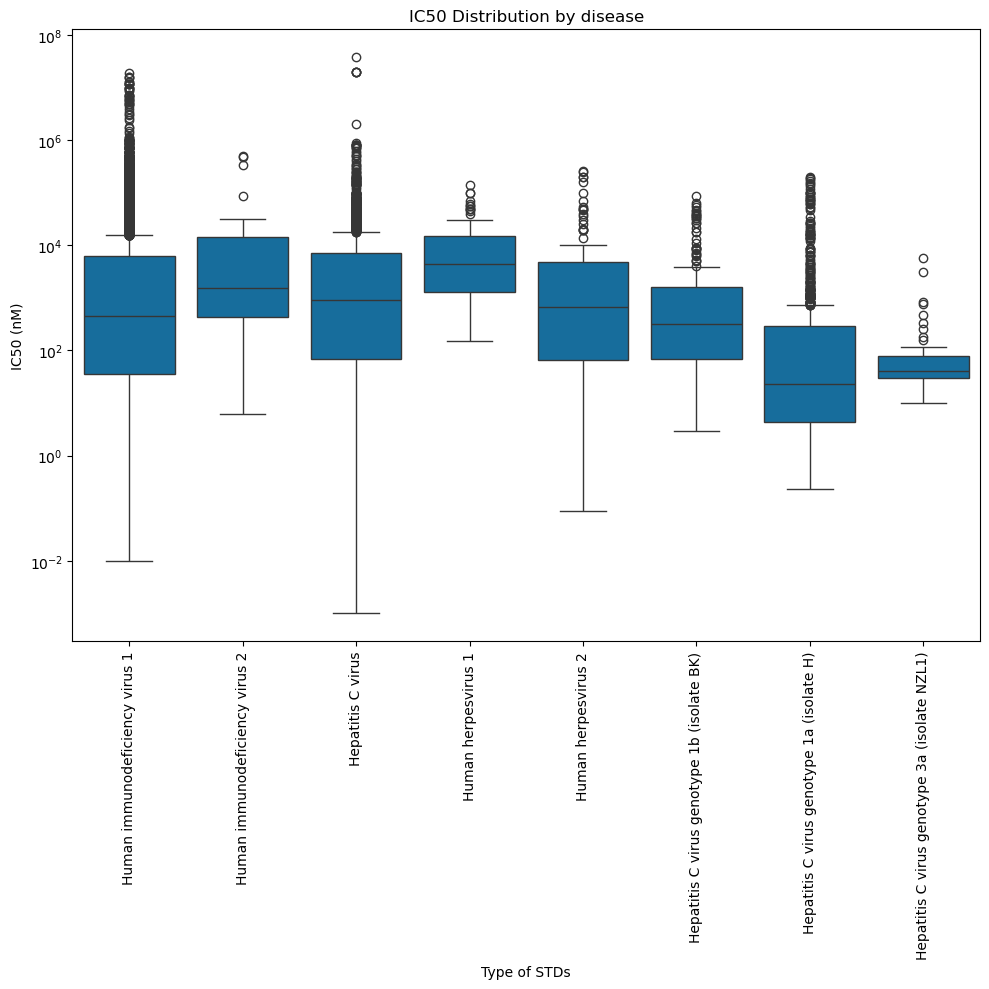

In [5]:
###box plot to see the distribution of ic50 in each type of stds
evaluation_utils.plot_ic50_boxplots(df)

Let's now plot with the `evaluation_utils.plot_organism_counts` function the frequencies of entries for all targets. The distribution we obtain is skewed, so we employ again a logarithmic scale

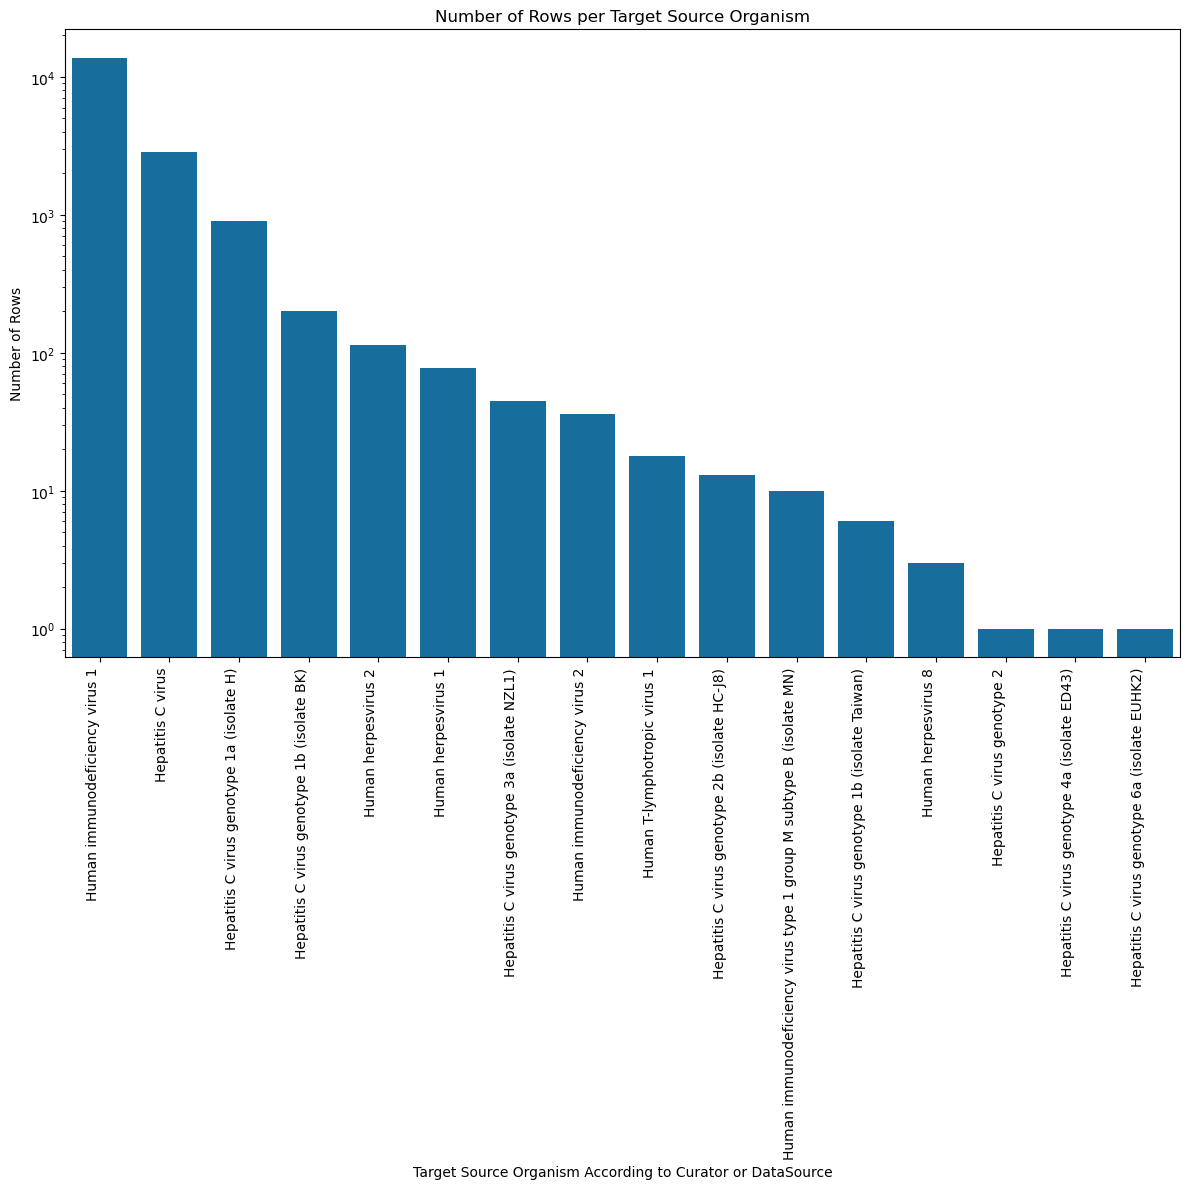

In [6]:
evaluation_utils.plot_organism_counts(df)

We observe that HIV 1 is clearly the most represented in the dataset (this type accounts for more than 95% of HIV infections worldwide (see https://doi.org/10.1093/infdis/jiad327)).  

For this preliminar analysis, we will focus on the HIV 1 subset of STD.  
Let's create a new `hiv` dataframe, containing only rows where the target is `Human immunodeficiency virus 1`

In [4]:
hiv = df[df['Target Source Organism According to Curator or DataSource'] == 'Human immunodeficiency virus 1']
print(f'HIV1 dataset rows: {hiv.shape[0]}')
print(f'HIV1 dataset columns: {hiv.shape[1]}')

HIV1 dataset rows: 13754
HIV1 dataset columns: 27


Through ... 

In [9]:
#create new df containing the DOI's
hiv_doi = hiv.copy()
doi_df = hiv_doi['Article DOI'].value_counts().reset_index()
# Applying  function 'get_publication_year' to each DOI in the dataframe:
doi_df['year'] = doi_df['Article DOI'].apply(lambda x : data_utils.get_publication_year(x))
doi_df
##merging the dataset to have a column contain the year
hiv_doi = pd.merge(hiv_doi, doi_df, on='Article DOI', how='outer')

Given the pandemic outbreak of HIV in the 1980s, it would be insightful to examine its temporal progression. Let's conduct a preliminary analysis to understand how the number of publications has evolved over time, providing an initial glimpse into the trends.

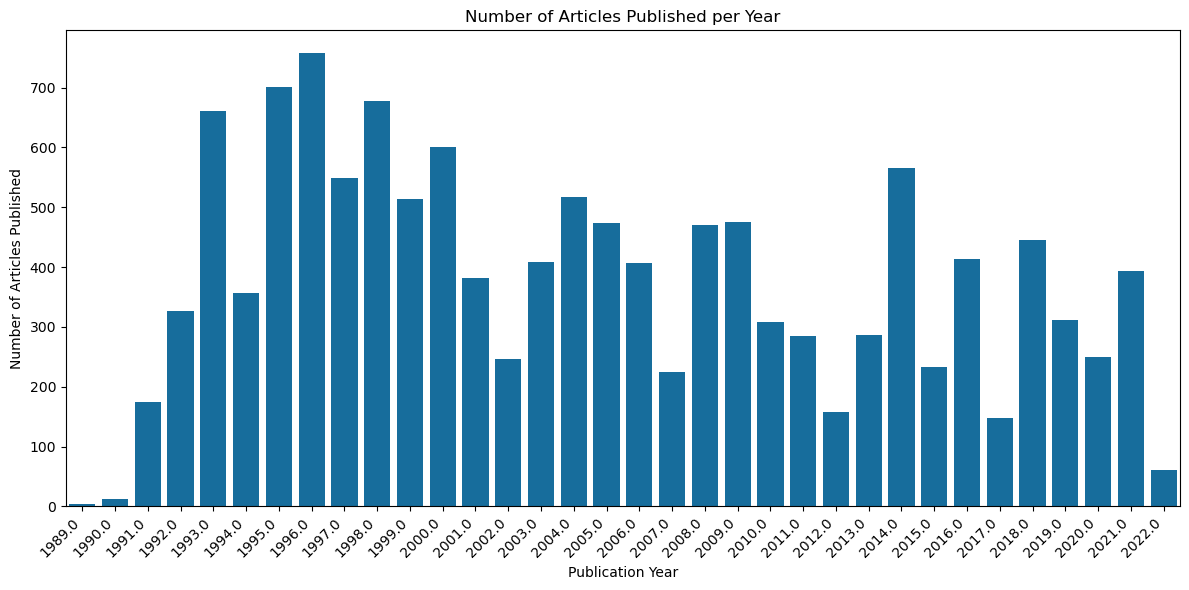

In [13]:
evaluation_utils.plot_publications_per_year(hiv_doi)

### RDKit expansion ###

After this cleaning phase, we can extract other molecular features with the external library 'Rdkit'.

We created the following functions: smiles_to_mol, calculate_descriptors, calculate_morgan_fingerprint.
These functions compute:
- 'smiles_to_mol': creates rdkit mol object from SMILES string
- 'calculate_descriptors': creates a dataframe with 12 features from the molecule
- 'calculate_morgan_fingerprint': extracts the morgan fingerprint for each molecule (with radius 2 and 2048 entries)ies)

Before doing this, we perform additional cleaning, removing unuseful columns and rows.

In [5]:
hivRD = hiv.copy()
hivRD = data_utils.nan_to_numeric(hivRD)

With the data ready, we can use the first function to get the 'mol' rdkit object from the molecule SMILES. This object will be used later to compute all features and the morgan fingerprints.

In [6]:
# Convert SMILES to RDKit Mol objects
hivRD['Mol'] = hivRD['Ligand SMILES'].apply(rdkit_extraction.smiles_to_mol)

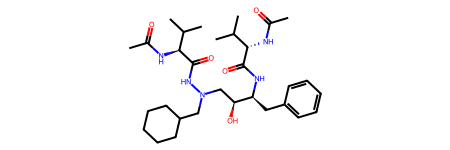

In [9]:
#try to print the first one, for seek of visualization
hivRD['Mol'][0]

Now we can compute all molecular descriptors starting from the 'Mol' column. The chosen descriptors are:
- **MolWt**: The molecular weight of the molecule, calculated as the sum of the atomic weights of all atoms present.
- **LogP**: The octanol-water partition coefficient (Log P), indicating the molecule's lipophilicity or hydrophobicity.
- **NumHDonors**: Number of hydrogen bond donors, typically counting hydrogen atoms attached to oxygen or nitrogen.
- **NumHAcceptors**: Number of hydrogen bond acceptors, such as oxygen or nitrogen atoms with lone pairs.
- **TPSA**: Topological Polar Surface Area, representing the surface area occupied by polar atoms; useful for predicting drug absorption.
- **NumRotatableBonds**: Number of rotatable bonds, affecting the molecule's flexibility.
- **NumAromaticRings**: Number of aromatic rings within the molecule.
- **NumAliphaticRings**: Number of aliphatic (non-aromatic) rings in the molecule.
- **FractionCSP3**: Fraction of sp³-hybridized carbons over total carbons, indicating the molecule's saturation level.
- **RingCount**: Total number of rings, both aromatic and aliphatic, present in the molecule.
- **FormalCharge**: The net formal charge of the molecule, calculated based on its electron configuration.
- **NumRadicalElectrons**: Number of unpaired (radical) electrons in the molecule.

In [7]:
# Calculate descriptors and add them to the DataFrame
descriptor_df = hivRD['Mol'].apply(lambda mol: rdkit_extraction.calculate_descriptors(mol))
hivRD = pd.concat([hivRD, descriptor_df], axis=1)

Now compute the morgan fingerprint for each molecule. The **Morgan fingerprint** is a type of molecular fingerprint that represents molecules based on their structural and topological features. It is generated by iteratively expanding each atom's neighborhood up to a specified radius, creating a unique identifier for each substructure. This identifier can then be hashed to a fixed-length bit vector, making it suitable for various similarity comparisons and machine learning applications.

The used rdkit parameters to generate them are:

- **Radius**: Controls the neighborhood size around each atom to include in the fingerprint. A common choice is `radius=2` (as chosen here), which captures the atom's environment up to two bonds away, balancing structural detail with compactness.
- **Bits**: Determines the length of the bit vector, usually specified in powers of 2 (e.g., 1024 or 2048 bits, as in this case). Higher bit counts reduce hash collisions but increase memory usage.

Morgan fingerprints can be especially useful alongside the previously generated molecular descriptors as they provide a comprehensive structural encoding. By representing a molecule's topology, Morgan fingerprints capture substructural similarities between molecules, which can be particularly valuable in tasks like drug discovery, where finding structurally similar molecules often correlates with similar biological activity.

In [8]:
# Calculate fingerprints and add them to the DataFrame
fingerprint_df = hivRD['Mol'].apply(lambda mol: rdkit_extraction.calculate_morgan_fingerprint(mol))
hivRD= pd.concat([hivRD, fingerprint_df], axis=1)

[17:19:25] DEPRECATION WARNING: please use MorganGenerator
[17:19:25] DEPRECATION WARNING: please use MorganGenerator
[17:19:25] DEPRECATION WARNING: please use MorganGenerator
[17:19:25] DEPRECATION WARNING: please use MorganGenerator
[17:19:25] DEPRECATION WARNING: please use MorganGenerator
[17:19:25] DEPRECATION WARNING: please use MorganGenerator
[17:19:25] DEPRECATION WARNING: please use MorganGenerator
[17:19:25] DEPRECATION WARNING: please use MorganGenerator
[17:19:25] DEPRECATION WARNING: please use MorganGenerator
[17:19:25] DEPRECATION WARNING: please use MorganGenerator
[17:19:25] DEPRECATION WARNING: please use MorganGenerator
[17:19:25] DEPRECATION WARNING: please use MorganGenerator
[17:19:25] DEPRECATION WARNING: please use MorganGenerator
[17:19:25] DEPRECATION WARNING: please use MorganGenerator
[17:19:25] DEPRECATION WARNING: please use MorganGenerator
[17:19:25] DEPRECATION WARNING: please use MorganGenerator
[17:19:25] DEPRECATION WARNING: please use MorganGenerat

Now try to see how the descriptors and fingerprint look like, to get a glimpse of what's inside. `descriptor_df` contains the expanded molecular features, while `fingerprint_df` contains the morgan fingerprints, that are in fact saved as bitvectors

In [12]:
descriptor_df.head()

,MolWt,LogP,NumHDonors,NumHAcceptors,TPSA,NumRotatableBonds,NumAromaticRings,NumAliphaticRings,FractionCSP3,RingCount,FormalCharge,NumRadicalElectrons
0,573.779,2.3097,5.0,6.0,139.87,15.0,1.0,1.0,0.677419,2.0,0.0,0.0
1,633.831,3.5297,5.0,8.0,158.33,17.0,1.0,1.0,0.696970,2.0,0.0,0.0
2,693.883,2.7827,5.0,10.0,176.79,21.0,1.0,1.0,0.714286,2.0,0.0,0.0
3,781.989,2.8159,5.0,12.0,195.25,27.0,1.0,1.0,0.743590,2.0,0.0,0.0
4,717.868,2.5911,6.0,9.0,205.08,17.0,3.0,1.0,0.473684,4.0,0.0,0.0


In [13]:
fingerprint_df.head()

0    [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2    [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...
3    [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...
4    [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: Mol, dtype: object

Now we can plot the correlation matrix of the numerical dataframe, to see some of the rdkit features are somehow correlated with IC50, or between them. To do this and further numerical analysis, we separate the numerical columns of the dataframe, creating a  `numerical_df` (which will be normalize to get all features in the same range), and the non numerical ones (including Morgan Fingerprints), in a `non_numerical_df`.

In [9]:
numerical_df, non_numerical_df = data_utils.separe_num_df(hivRD)
numerical_df = (numerical_df - numerical_df.min())/(numerical_df.max() - numerical_df.min())
numerical_df = numerical_df.drop(columns=['NumRadicalElectrons']) #column dropped as it was all 0-valued

In [15]:
corr1 = numerical_df.corr()
corr1.style.background_gradient(cmap='coolwarm')

,index,BindingDB Reactant_set_id,BindingDB MonomerID,IC50 (nM),Number of Protein Chains in Target (>1 implies a multichain complex),MolWt,LogP,NumHDonors,NumHAcceptors,TPSA,NumRotatableBonds,NumAromaticRings,NumAliphaticRings,FractionCSP3,RingCount,FormalCharge
index,1.000000,0.835198,0.664504,0.046418,-0.586478,-0.020821,-0.038268,-0.001477,0.083867,0.048646,-0.028124,0.081438,-0.112546,-0.146154,-0.009646,0.001653
BindingDB Reactant_set_id,0.835198,1.000000,0.805742,0.042839,-0.675903,0.043416,-0.134370,0.113251,0.165865,0.144221,0.051956,0.066459,-0.084358,-0.123235,-0.003015,-0.032390
BindingDB MonomerID,0.664504,0.805742,1.000000,-0.009987,-0.546274,0.101950,-0.106433,0.139959,0.229100,0.186627,0.112749,0.125136,-0.115581,-0.106915,0.022386,-0.041575
IC50 (nM),0.046418,0.042839,-0.009987,1.000000,-0.028515,-0.037988,-0.034637,-0.014164,-0.031680,-0.013304,-0.024761,-0.032354,-0.036154,-0.061643,-0.048629,-0.010807
Number of Protein Chains in Target (>1 implies a multichain complex),-0.586478,-0.675903,-0.546274,-0.028515,1.000000,-0.173040,0.016909,-0.165639,-0.219695,-0.188905,-0.153409,-0.096336,-0.028169,-0.055795,-0.093234,0.021033
MolWt,-0.020821,0.043416,0.101950,-0.037988,-0.173040,1.000000,-0.009607,0.836867,0.813082,0.888415,0.920789,0.450098,0.274136,0.392346,0.528069,-0.013595
LogP,-0.038268,-0.134370,-0.106433,-0.034637,0.016909,-0.009607,1.000000,-0.359194,-0.310026,-0.357975,-0.145649,0.348190,0.121134,-0.046936,0.349514,0.124818
NumHDonors,-0.001477,0.113251,0.139959,-0.014164,-0.165639,0.836867,-0.359194,1.000000,0.744638,0.924585,0.858608,0.286081,0.093083,0.257050,0.282989,0.028341
NumHAcceptors,0.083867,0.165865,0.229100,-0.031680,-0.219695,0.813082,-0.310026,0.744638,1.000000,0.899647,0.776815,0.316418,0.138455,0.274518,0.336029,-0.141394
TPSA,0.048646,0.144221,0.186627,-0.013304,-0.188905,0.888415,-0.357975,0.924585,0.899647,1.000000,0.887281,0.316662,0.098672,0.253472,0.310409,-0.086834


 We can see that IC50 is not particularly correlated with other features, but there are other features which are correlated between them. To exploit this effect, interaction terms between highly correlated variables (as and ) were added and IC50 transformations were tested (to not include too many things, these matrices are shown in ''), but none of them led to higher correlations between affinity and other features. Another possibility was to recompute correlation just on high affinity drugs, to see if they somehow differ from other ones.

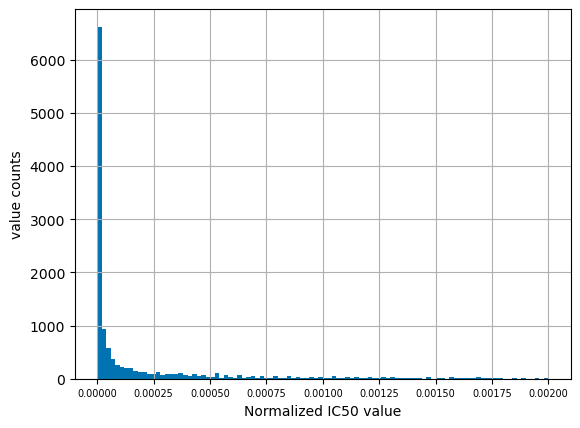

In [10]:
numerical_df['IC50 (nM)'][numerical_df['IC50 (nM)'] < 0.002].hist(bins=100)
plt.xticks(fontsize=7)
plt.xlabel('Normalized IC50 value')
plt.ylabel('value counts')
plt.show()

A threshold of 0.00017 to define a high affinity drug was set based on the IC50 distribution. Still, almost nothing changed in terms of correlation.

In [11]:
#Now we can filter the data including only high affinity ligands with the above mentioned threshold
df_low_IC50 = numerical_df[numerical_df['IC50 (nM)'] < 0.00017]
corrlic =df_low_IC50.corr()
corrlic.style.background_gradient(cmap='coolwarm')

,index,BindingDB Reactant_set_id,BindingDB MonomerID,IC50 (nM),Number of Protein Chains in Target (>1 implies a multichain complex),MolWt,LogP,NumHDonors,NumHAcceptors,TPSA,NumRotatableBonds,NumAromaticRings,NumAliphaticRings,FractionCSP3,RingCount,FormalCharge
index,1.000000,0.868844,0.707065,0.021289,-0.594234,-0.007873,-0.023015,0.017085,0.118551,0.084718,-0.015093,0.105553,-0.134502,-0.185697,-0.007882,-0.002307
BindingDB Reactant_set_id,0.868844,1.000000,0.804635,0.073852,-0.657126,0.034627,-0.114833,0.102765,0.158542,0.137033,0.046994,0.086198,-0.101897,-0.141909,-0.001361,-0.020105
BindingDB MonomerID,0.707065,0.804635,1.000000,0.085464,-0.529525,0.090436,-0.076509,0.128682,0.225470,0.180478,0.108523,0.160205,-0.147508,-0.143311,0.024231,-0.028177
IC50 (nM),0.021289,0.073852,0.085464,1.000000,0.049344,-0.111069,-0.121944,-0.037097,-0.037403,-0.032369,-0.073209,-0.025309,-0.035967,-0.145827,-0.041705,-0.005102
Number of Protein Chains in Target (>1 implies a multichain complex),-0.594234,-0.657126,-0.529525,0.049344,1.000000,-0.215518,-0.028075,-0.190149,-0.249216,-0.217133,-0.196249,-0.111392,-0.040032,-0.107058,-0.107974,0.011762
MolWt,-0.007873,0.034627,0.090436,-0.111069,-0.215518,1.000000,0.093652,0.823530,0.799965,0.877840,0.913632,0.462593,0.335310,0.397034,0.556444,0.016383
LogP,-0.023015,-0.114833,-0.076509,-0.121944,-0.028075,0.093652,1.000000,-0.290773,-0.211171,-0.267151,-0.059612,0.399890,0.124063,-0.025030,0.375065,0.114785
NumHDonors,0.017085,0.102765,0.128682,-0.037097,-0.190149,0.823530,-0.290773,1.000000,0.725988,0.916009,0.851666,0.275633,0.140581,0.267182,0.293713,0.045597
NumHAcceptors,0.118551,0.158542,0.225470,-0.037403,-0.249216,0.799965,-0.211171,0.725988,1.000000,0.891610,0.779822,0.344114,0.156019,0.258443,0.354232,-0.093961
TPSA,0.084718,0.137033,0.180478,-0.032369,-0.217133,0.877840,-0.267151,0.916009,0.891610,1.000000,0.880897,0.333959,0.140038,0.240951,0.336507,-0.047925


## Tanimoto Similarity with Morgan Fingerprints ##

 
The previous findings convinced us to make further analysis, suggesting that maybe these molecular features aren't enough to fully capture ligands charateristics. For this reason, successive ones are conducted on Morgan Fingerprints similarities, which potentially convey more informations. As there are more or less 9000 molecules, compute the similarity between each pair is not feasible. For this reason, similarity is more likely to be computed from each couple of a sample of size s out of these 9000. But what value should be given to s? The answer can be given considering a trade-off between statistical significance (not too low s) and computational resources (not too high). Considering that for a population of size N an ideal value starts from \sqrt{N}, the lower bound for s is around 94. The upper bound can be obtained by experimenting different values.After some experiments, a sample size of 5000 is taken.

These 5000 samples will be extracted without replacement from the initial dataset (filtered by low IC50 values)

In [12]:
df_sample = data_utils.create_df_mf(non_numerical_df, df_low_IC50)

Now that we have morgan fingerprints for high affinity ligands, we can see if they are somehow similar, trying different methods.
The first step is to compute Tanimoto similarity between each pair of ligands, and store them in a similarity matrix (in this case of size 5000 x 5000). This score is used because it's accurate to compare each bit of each fingerprint, to catch possible structural similarities.

In [13]:
similarities, similarity_matrix =  rdkit_extraction.compute_tanimoto_similarities(df_sample)

To get a first glimpse of the data, we can visualize this matrix with a heatpamp, to see if there are some evident patterns

<Axes: >

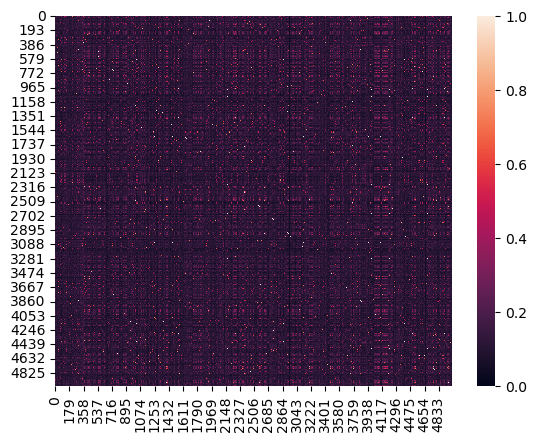

In [20]:
#Now we can try to plot the similarity matrix with a heatmap, to see if there are some evident similarities
sns.heatmap(similarity_matrix)

Some samples look similar (there are few bright spots), but the majority of the couples have similarity lower than 0.3, indicating that we should use other methods to understand how such ligands are similar.

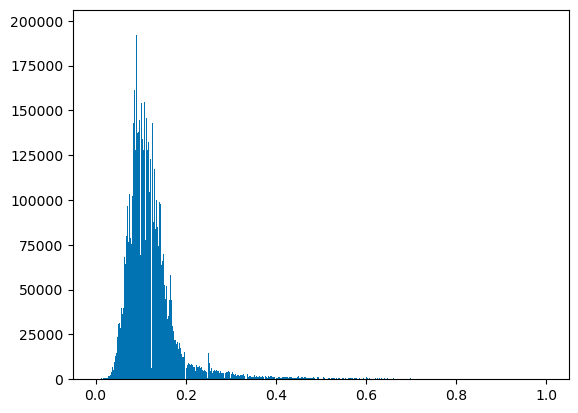

In [21]:
plt.hist(similarities, bins=1000)
plt.show()

The distribution confirms that the majority of the similarity values lie below 0.3. This can be further verified with some summary statistics.

In [22]:
avg_similarity = np.mean(similarities)
min_similarity = np.min(similarities)
max_similarity = np.max(similarities)

print(f'Average similarity: {avg_similarity}')
print(f'Min similarity: {min_similarity}')
print(f'Max similarity: {max_similarity}')

Average similarity: 0.12599911324347743
Min similarity: 0.0
Max similarity: 1.0


## Clustering ##

This and other findings (present in the file ''), convinced us to exploit other methods to see if there are similarities between high affinity compounds. Specifically, using clustering can identify more deep patterns between molecules. This approach can be potentially applied to:

- **Molecular features**: Rdkit features extracted from SMILES strings;
- **Morgan Fingerprints**;
- **Similarity matrix** between morgan fingerprints.

**Molecular features** are suitable for K-means, as the number of features is not too high, so that euclidean distance is meaningful to discriminate between them. With the same argument, K-means won't be used on **Morgan Fingerprints**, as 2048 features are too many, leading to a possible curse of dimensionality (also, it's not too meaningful as they are bitvectors). However, using **Similarity matrix** instead of fingerprints can bring meaningful insights. Specifically, spectral clustering can be run on such matrix. With these two approaches, we will be possibly be able to group ligands based on more general molecular features as well as more 'complex' structural patterns.

### K-means on molecular features ###

First, we can run K-means on the original df_low_IC50 dataframe (as now using all 9000 features is computationally feasible). Then, clustering results can be visualized along the first two or three principal components, to see how their shape describes them. To decide the number of clusters we can use the elbow method.


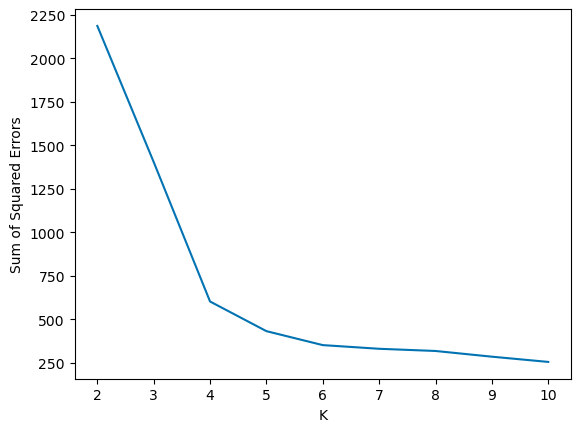

In [14]:
from sklearn.cluster import KMeans,SpectralClustering
#plot SSE against K to look for the elbow
evaluation_utils.plot_sse(df_low_IC50)

The optimal value is clearly 4.

In [15]:
k = 4  # Number of clusters, chosen based on above elbow method
km = KMeans(n_clusters=k, random_state=42)
clusters_km = km.fit_predict(df_low_IC50)
df_low_IC50['km_Cluster'] = clusters_km
print(df_low_IC50.groupby('km_Cluster').size())  # Check the size of each cluster

km_Cluster
0     950
1    1605
2    1440
3    5459
dtype: int64


C:\Users\Utente\AppData\Local\Temp\ipykernel_3600\679298676.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_low_IC50['km_Cluster'] = clusters_km


The cluster numerical size is not too unbalanced, suggesting a meaningful capturing of underlyng similarities between ligands. At last, we can visualize 2D and 3D PCA.

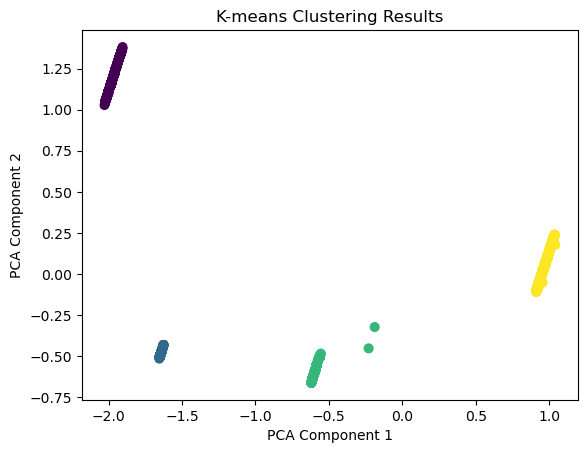

In [16]:
evaluation_utils.plot_pca_2d(df_low_IC50, clusters_km, kmc=True)

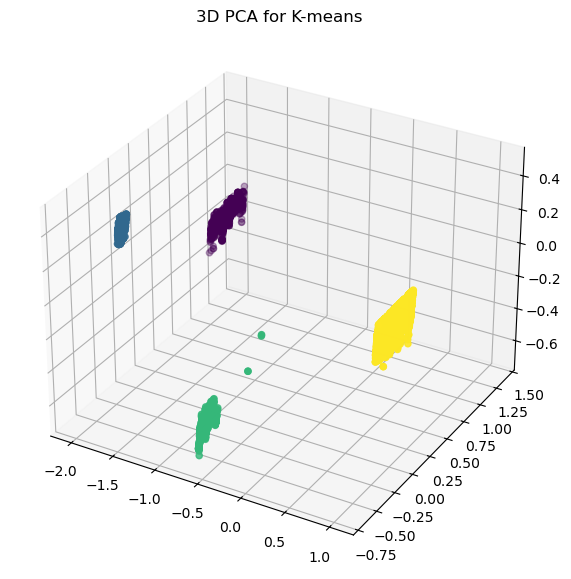

In [17]:
evaluation_utils.plot_pca_3d(df_low_IC50, clusters_km, kmc=True)

From the PCA we can first notice that the clusters are very well defined and well separated, suggesting that there are four distinct possible molecular 'classes' between high affinity compounds. Wen can notice for all of them an intra-cluster variability along axis Z (third principal component), and really low variability along other axis. For what concenrn inter-class variability, the clusters are well separated along X and Y axis, and less along Z. Still, potentially these clusters can be used as classes in a possible multiclass classification drug prediction.

### Spectral Clustering on Similarity Matrix ###

Now spectral clustering will be applied to the Tanimoto similarity matrix. Because 'normal' elbow method can't be used here, the number of clusters was manually set after some attempts to 4. This clustering can potentially catch even more deep relationships between molecules, being executed on similarity based on morgan fingerprints. The sampled dataframe is now used, as it's the reference for the similarity matrix

In [18]:
k = 4  # Number of clusters, also here chosen based on above elbow method (not completely correct but still tried)
spc = SpectralClustering(n_clusters=k, random_state=42, affinity='precomputed')
clusters_sp = spc.fit_predict(similarity_matrix)
df_sample['sm_Cluster'] = clusters_sp
print(df_sample.groupby('sm_Cluster').size())  #clusters size

sm_Cluster
0    1220
1    3083
2     140
3     557
dtype: int64


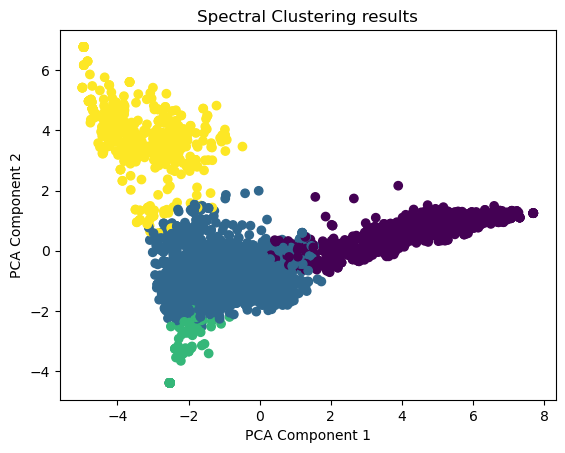

In [19]:
evaluation_utils.plot_pca_2d(similarity_matrix, clusters_sp, kmc=False)

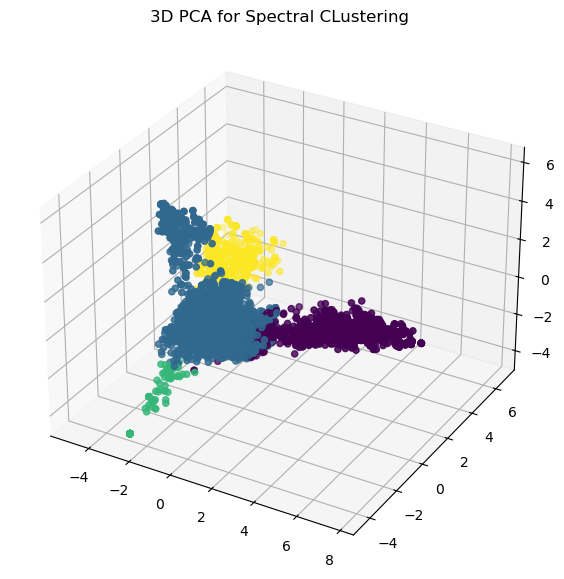

In [21]:
evaluation_utils.plot_pca_3d(similarity_matrix, clusters_sp, kmc=False)

We can see that the data are in 4 distinct and not too overlapped clusters. But what does this mean?
First of all, a little recap of how these data were obtained. The initial dataframe was filtered to include just high-affinity ligands (with IC50 below 0.00017, saw from the distribution plot). Then, Morgan fingerprints of such compounds were extracted, and a similarity matrix between them was computed. The similarity metric is the 'tanimoto' score, where 1 indicates perfectly overlapping bits and 0 totally different.
Then, spectral clustering is applied to this matrix, as K-means is not the best choice for a similarity matrix. These visualizations are an indication of the fact that maybe the complexity of morgan fingerprints led to less separated clusters, also remembering that the original dimensions were 5000, now reduced to 2 or 3, so it's possible that the classes are more separate in higher dimensions. Still, this is another interesting molecular subdivision based on their structure, rather than on previously tested molecular features

Now, we can try and observe the distribution of our IC50 parameter. Typically, IC50 values in the low nanomolar (nM) range, such as 1–100 nM, are considered very potent. The range of IC50 values can vary widely depending on the specific biological system, target, and experimental conditions.  

Compounds with IC50 values in the 100 nM – 1 µM (1000 nM) range are moderately potent. Above 1 µM (1000 nM) are the drugs that are considered to have a lower affinity for their target.  

When we have very high IC50 values, in the range of several µM (micromolar) to mM (millimolar), the compound is considered not effective at binding its target and often must be optimized for potency.


In [ ]:
df['IC50 (nM)'].describe()

count    1.802600e+04
mean     3.920599e+04
std      5.866093e+05
min      1.000000e-03
25%      3.500000e+01
50%      4.400000e+02
75%      5.900000e+03
max      3.815000e+07
Name: IC50 (nM), dtype: float64

<Axes: ylabel='IC50 (nM)'>

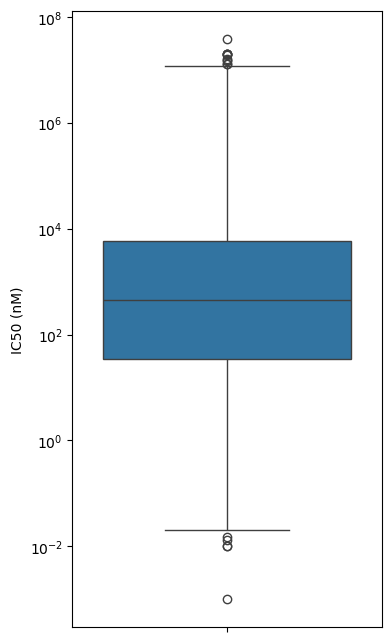

In [ ]:
# set the figure size
plt.figure(figsize=(4, 8))

### create the boxplot
sns.boxplot(y=df['IC50 (nM)'], log_scale=True)

We can see that our data spans a large range, therefore in order to be able to properly see the smaller values and show a more interpretable visualization we can use a logarithmic compression. This log-log transformation can reveal patterns across data that spans several orders of magnitude, both in terms of IC50 values (x-axis) and counts (y-axis).


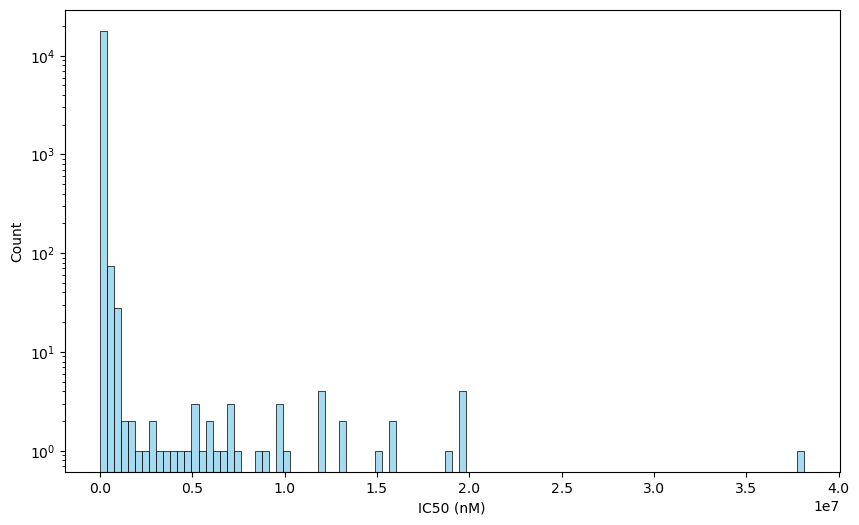

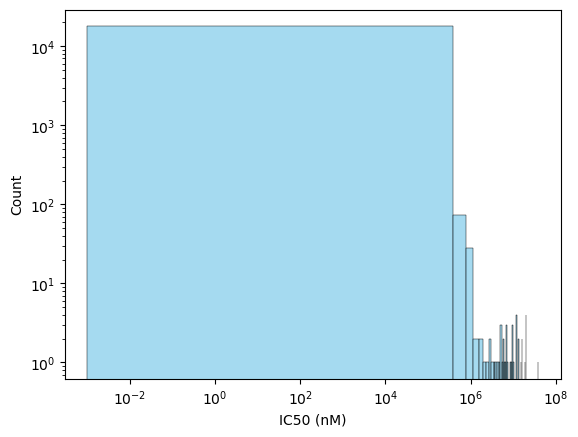

In [ ]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Create the histogram using Seaborn with a logarithmic scale
sns.histplot(df['IC50 (nM)'], bins=100, kde=False, color='skyblue')

# Set the y-axis only to a logarithmic scale
#plt.xscale('log')
plt.yscale('log')
plt.show()

#Set both x-axis and y-axis to a logarithmic scale (bins = 100 instructs the histogram to split the data in 100 equally spaced bins,
# regarding the range of our parameter. 
# We will have smaller bins as we go towards the right, as larger numbers will be more compressed)
sns.histplot(df['IC50 (nM)'], bins=100, kde=False, color='skyblue')
plt.xscale('log')
plt.yscale('log')